In [4]:
import sqlite3
import json
import pandas as pd
DB_PATH = 'data/experiments.db'

In [6]:
get_last_experiments_ids(2)

[243, 242]

In [5]:
def get_last_experiments_ids(n):
    with sqlite3.connect(DB_PATH) as conn:
        # SQL query to get the last n experiment IDs
        query = f"""
        SELECT experiment_id
        FROM Experiment
        ORDER BY experiment_id DESC
        LIMIT {n}
        """

        # Execute the query and fetch results
        cursor = conn.execute(query)
        experiment_ids = cursor.fetchall()

    # Flatten the list of tuples and return the experiment IDs
    return [id_tuple[0] for id_tuple in experiment_ids]


def get_experiments_details(experiment_ids):
    with sqlite3.connect(DB_PATH) as conn:
        # Convert list of experiment_ids to a string format suitable for the SQL query
        formatted_ids = ','.join(map(str, experiment_ids))

        # SQL query to get the desired information
        query = f"""
        SELECT 
            E.experiment_id, 
            E.start_time, 
            E.config_id, 
            json_extract(EC.agent_config, '$.agent_id') AS agent_id,
            json_extract(EC.agent_config, '$.matrices_mode') AS matrices_mode,
            json_extract(EC.gridlink_config, '$.grid_shape') AS grid_shape,
            json_extract(EC.gridlink_config, '$.n_predictable_cycles') AS n_predictable_cycles,
            json_extract(EC.gridlink_config, '$.n_unpredictable_cycles') AS n_unpredictable_cycles,
            json_extract(EC.agent_config, '$.n_obs') AS n_obs,
            json_extract(EC.agent_config, '$.n_states') AS n_states,
            (SELECT COUNT(*) FROM Steps WHERE Steps.experiment_id = E.experiment_id) AS steps_count
        FROM Experiment AS E
        JOIN ExperimentConfig AS EC ON E.config_id = EC.config_id
        WHERE E.experiment_id IN ({formatted_ids})
        """

        # Execute the query and fetch results directly into a pandas DataFrame
        df = pd.read_sql_query(query, conn)

    # Return the DataFrame
    return df

def prepare_experiment_data(experiment_id):
    with sqlite3.connect(DB_PATH) as conn:
        # Query to get the steps for the given experiment_id
        query = f"""
        SELECT 
            step_num, 
            agent_action, 
            environment_state
        FROM Steps
        WHERE experiment_id = {experiment_id}
        ORDER BY step_num
        """

        # Execute the query and fetch results directly into a pandas DataFrame
        df = pd.read_sql_query(query, conn)


        # Deserialize the agent_action binary data and map it to 0 or 1
        df['agent_action'] = df['agent_action'].apply(lambda x: 1 if x == b'\x00\x00\x00\x00\x00\x00\xf0?' else 0)

        # Parse the environment_state JSON string and create new columns
        df['status'] = df['environment_state'].apply(lambda x: json.loads(x)['status'])
        df['score'] = df['environment_state'].apply(lambda x: json.loads(x)['rally'])
        df['ball_y'] = df['environment_state'].apply(lambda x: json.loads(x)['ball_y'])
        df['paddle_y'] = df['environment_state'].apply(lambda x: json.loads(x)['paddle_y'])

        # Calculate the ball_paddle_alignment
        df['ball_paddle_alignment'] = df['paddle_y'] - df['ball_y']

        # Drop the original environment_state column
        df.drop('environment_state', axis=1, inplace=True)
        df.drop(['ball_y','paddle_y'], axis=1, inplace=True)
        # df.drop(['paddle_y','ball_y'],inplace=True)

    # Return the DataFrame with the new structure
    return df

In [58]:
experiment_ids = list(range(100,226))
get_experiments_details(experiment_ids)

,experiment_id,start_time,config_id,agent_id,matrices_mode,grid_shape,n_predictable_cycles,n_unpredictable_cycles,n_obs,n_states,steps_count
0,100,2023-11-04 14:06:34,46,None,None,"[2,3]",10,400,3,2,3961
1,101,2023-11-04 14:10:05,47,None,None,"[2,3]",10,400,8,2,130
2,102,2023-11-04 14:10:15,48,None,None,"[2,3]",10,400,8,3,354
3,103,2023-11-04 14:10:37,49,None,None,"[2,3]",10,400,8,3,732
4,104,2023-11-04 14:11:06,50,None,None,"[2,3]",10,400,8,8,1275
...,...,...,...,...,...,...,...,...,...,...,...
121,221,2023-11-07 09:24:16,90,radom,None,"[2,3]",4,800,8,8,0
122,222,2023-11-07 09:24:47,91,random,None,"[2,3]",4,800,8,8,50000
123,223,2023-11-08 01:34:12,92,None,uniform,"[2,3]",4,800,8,8,1718
124,224,2023-11-08 01:35:17,93,None,uniform,"[2,3]",10,400,8,8,50000


In [53]:
ex_255 = prepare_experiment_data(225)

In [56]:
def calculate_metrics(df):
    # Calculate hits and misses
    df['hits'] = (df['status'] == 1).cumsum()
    df['misses'] = (df['status'] == -1).cumsum()

    # Avoid division by zero for hit_miss_ratio
    df['hit_miss_ratio'] = df['hits'] / df['misses'].replace({0: 1})

    # Calculate long rallies
    df['long_rallies'] = (df['score'] >= 3).cumsum()

    # Calculate aces
    df['aces'] = ((df['status'] == -1) & (df['score'].shift(1) == 0)).cumsum()

    return df[['step_num', 'hits', 'misses', 'hit_miss_ratio', 'long_rallies', 'aces']]

def calculate_metrics2(df):
    # Calculate hits and misses
    df['hits'] = (df['status'] == 1).cumsum()
    df['misses'] = (df['status'] == -1).cumsum()

    # Avoid division by zero for hit_miss_ratio
    df['hit_miss_ratio'] = df.apply(lambda x: x['hits'] / x['misses'] if x['misses'] > 0 else 0, axis=1)

    # Calculate long rallies
    df['long_rallies'] = (df['score'] >= 3).cumsum()

    # Calculate aces
    df['previous_score'] = df['score'].shift(1, fill_value=0)
    df['aces'] = ((df['status'] == -1) & (df['previous_score'] == 0)).cumsum()

    # Select only the relevant columns to return
    metrics_df = df[['step_num', 'hits', 'misses', 'hit_miss_ratio', 'long_rallies', 'aces']]
    
    return metrics_df


<Axes: xlabel='step_num', ylabel='hit_miss_ratio'>

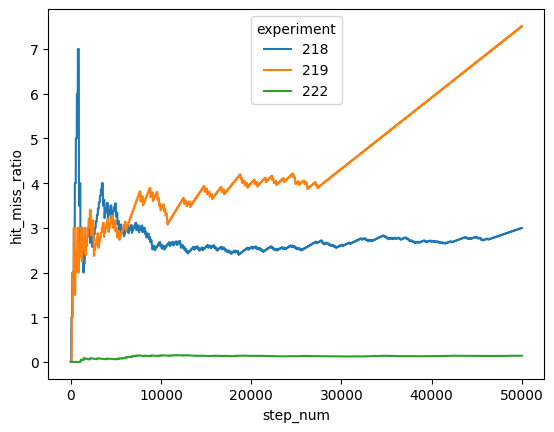

In [52]:
import seaborn as sns
import pandas as pd

# Reset the index so 'step_num' becomes a column
ex218_metrics = calculate_metrics(prepare_experiment_data('218'))
ex219_metrics = calculate_metrics(prepare_experiment_data('219'))
ex222_metrics = calculate_metrics(prepare_experiment_data('222'))

# Add an 'experiment' column to distinguish between the two datasets
ex218_metrics['experiment'] = '218'
ex219_metrics['experiment'] = '219'
ex222_metrics['experiment'] = '222'

# Concatenate the two DataFrames into one
combined_metrics = pd.concat([ex218_metrics,ex219_metrics,ex222_metrics])

# Now plot using seaborn
sns.lineplot(data=combined_metrics, x='step_num', y='hit_miss_ratio', hue='experiment')


<Axes: xlabel='step_num', ylabel='hit_miss_ratio'>

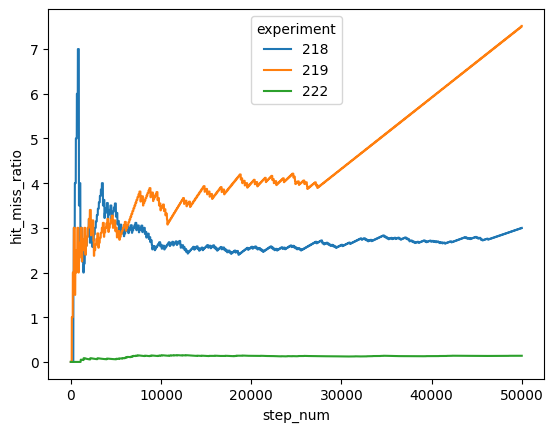

In [57]:
import seaborn as sns
import pandas as pd

# Reset the index so 'step_num' becomes a column
ex218_metrics = calculate_metrics2(prepare_experiment_data('218'))
ex219_metrics = calculate_metrics2(prepare_experiment_data('219'))
ex222_metrics = calculate_metrics2(prepare_experiment_data('222'))

# Add an 'experiment' column to distinguish between the two datasets
ex218_metrics['experiment'] = '218'
ex219_metrics['experiment'] = '219'
ex222_metrics['experiment'] = '222'

# Concatenate the two DataFrames into one
combined_metrics = pd.concat([ex218_metrics,ex219_metrics,ex222_metrics])

# Now plot using seaborn
sns.lineplot(data=combined_metrics, x='step_num', y='hit_miss_ratio', hue='experiment')
